# Learned iterative solver for CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fifth notebook is to train a Learned Iterative Solver to invert the CTscan imaging operator in a supervised manner. Similar to the previous example, we will be using a training dataset composed of several brain images and their corresponding FBP results for a CT aquisition with poor angle coverage. We wish to train a network to transform the FBP images into those of higher quality (assumed to be obtained using a a CT aquisition with better angle coverage), whilst using at the same time the knowledge of the acquisition system in the form of the gradient of the following data misfit norm: $ \Vert \mathbf{d}- \mathbf{G}\mathbf{x} \Vert_2^2$

The problem that we wish to solve can be expressed as:

$$
\underset{\theta} {\mathrm{argmin}} \; \Vert \mathbf{x}- f_\theta(\mathbf{x}_{FBP}) \Vert_2^2
$$

where $f_\theta$ is a deep unrolled network mimicking a proximal gradient descent algorithm (where the network acts the proximal operator)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from pylops import TorchOperator
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from ct import CT2D
from learnedtrain import *
from learned import Learned
from plotting import plt_comparison

device = 'cpu'
trainnet = False # True: run training, False: load pre-trained network

## Load training dataset

In [34]:
# Load data
f = np.load('../data/brains_fbp_trainingdata.npz')
brains = f['brains'][:500] # number of samples is 1380
brainsfbp = f['fbps'][:500]
sinograms = f['sinograms'][:500]
nx, ny = brains.shape[1:]

# Remove 10th element, always used to test different imaging algorithm
brain_test = brains[10]
brainfbp_test = brainsfbp[10]
sinogram_test = sinograms[10]
brains = np.delete(brains, 10, axis=0)
brainsfbp = np.delete(brainsfbp, 10, axis=0)
sinograms = np.delete(sinograms, 10, axis=0)

(500, 41, 160)


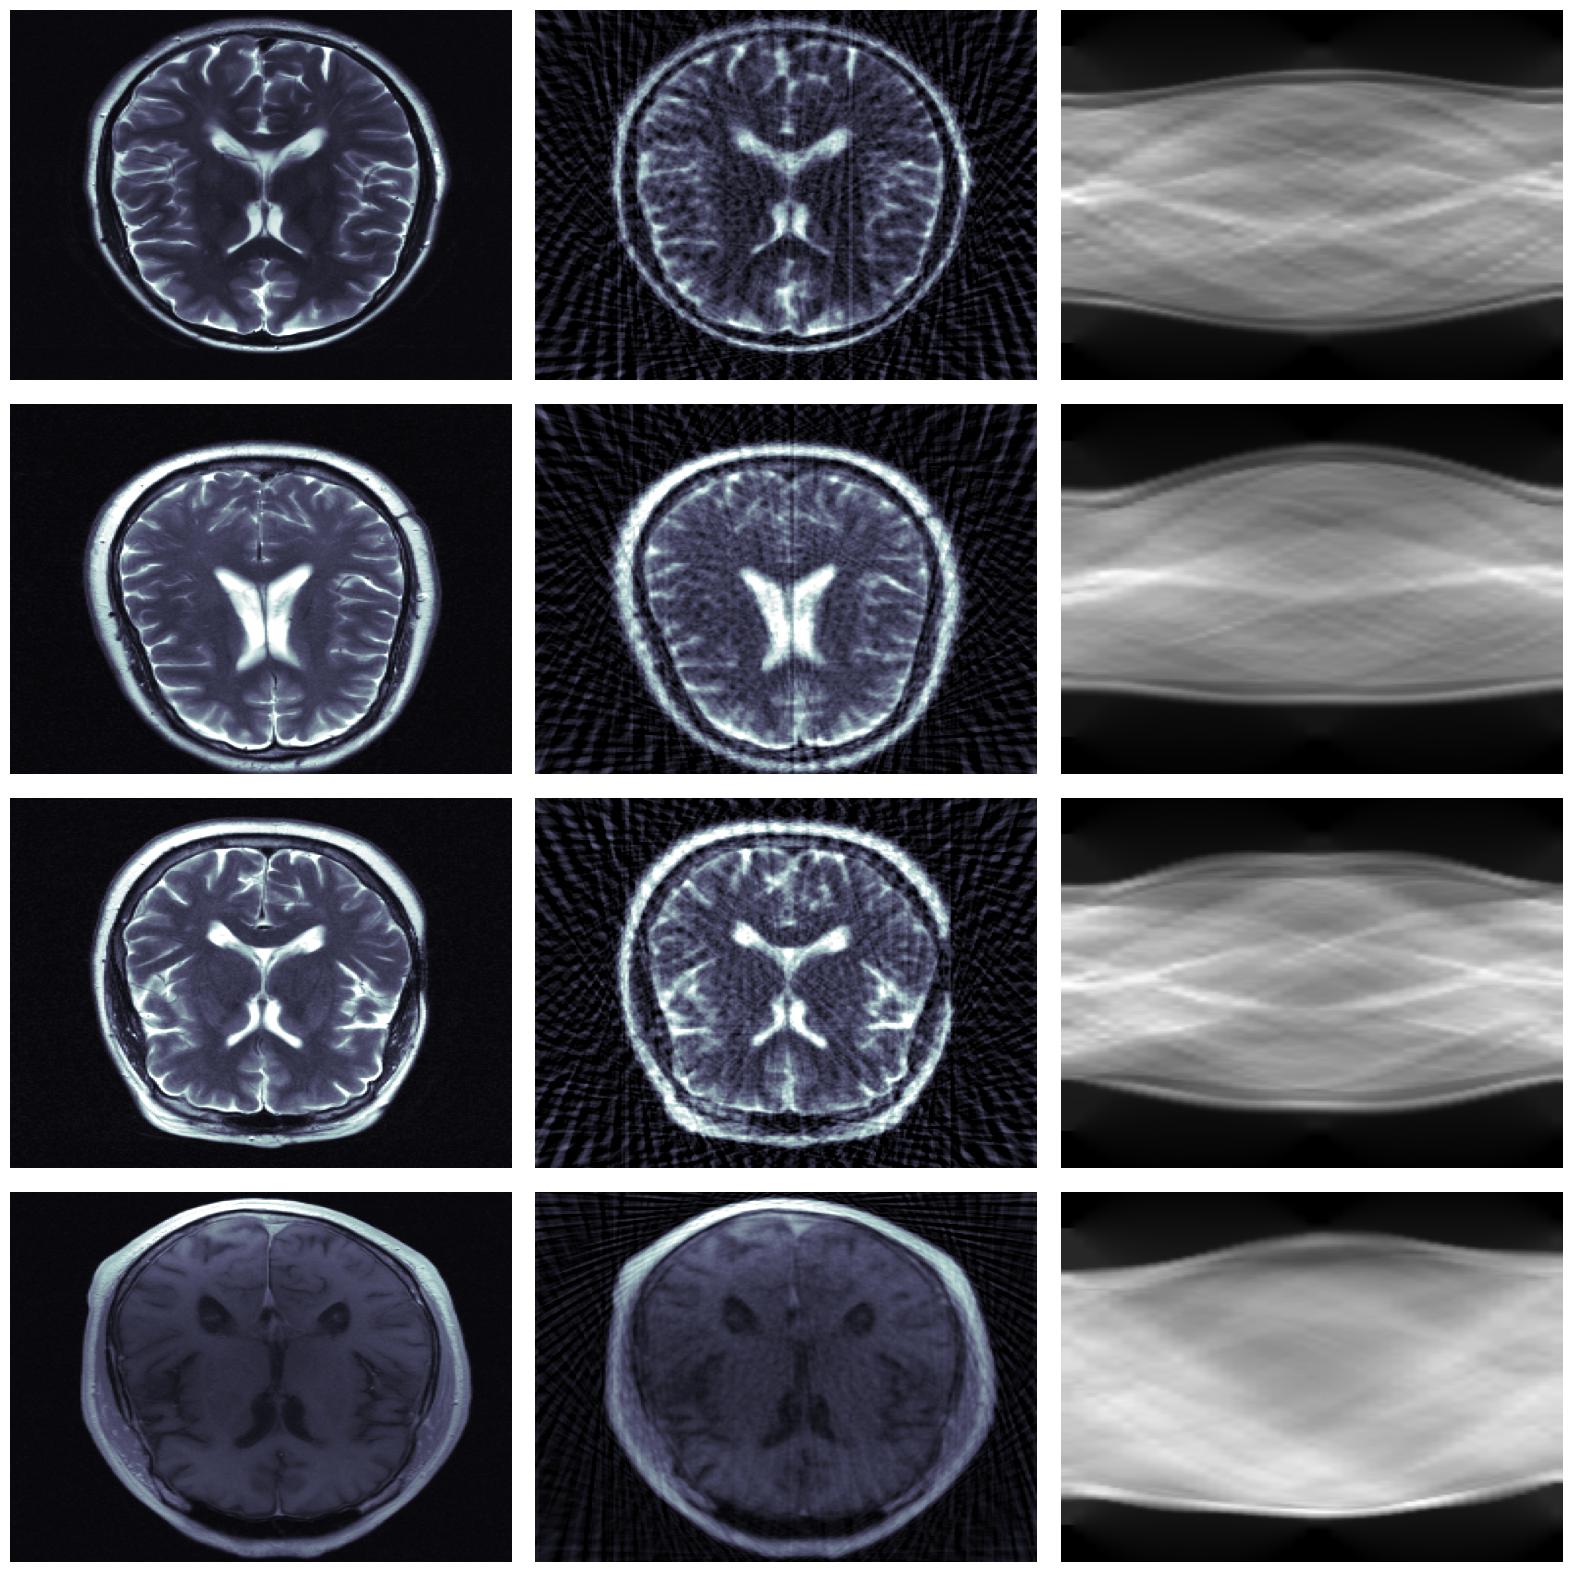

In [3]:
iimages = np.random.randint(0, len(brains), 4)
fig, axs = plt.subplots(4, 3, figsize=(16, 16))

for iax, iimage in enumerate(iimages):
    axs[iax, 0].imshow(brains[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 0].axis("tight")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(brainsfbp[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 1].axis("off")
    axs[iax, 1].axis("tight")
    axs[iax, 2].imshow(sinograms[iimage].T, cmap="gray")
    axs[iax, 2].axis("off")
    axs[iax, 2].axis("tight")
plt.tight_layout()

In [4]:
# Create operator
nangles = 41
distdetectors = 2
ndetectors = 160

Cop = CT2D((nx, ny), distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False))
Cop_torch = TorchOperator(Cop, batch=False)

dottest(Cop, atol=1e-3, verb=True);

Dot test passed, v^H(Opu)=486.7353807259368 - u^H(Op^Hv)=486.73583215568334


In [5]:
# Test that operator produces the same data as the one pre-computed and loaded from file
np.allclose(sinogram_test, Cop @ brain_test)

True

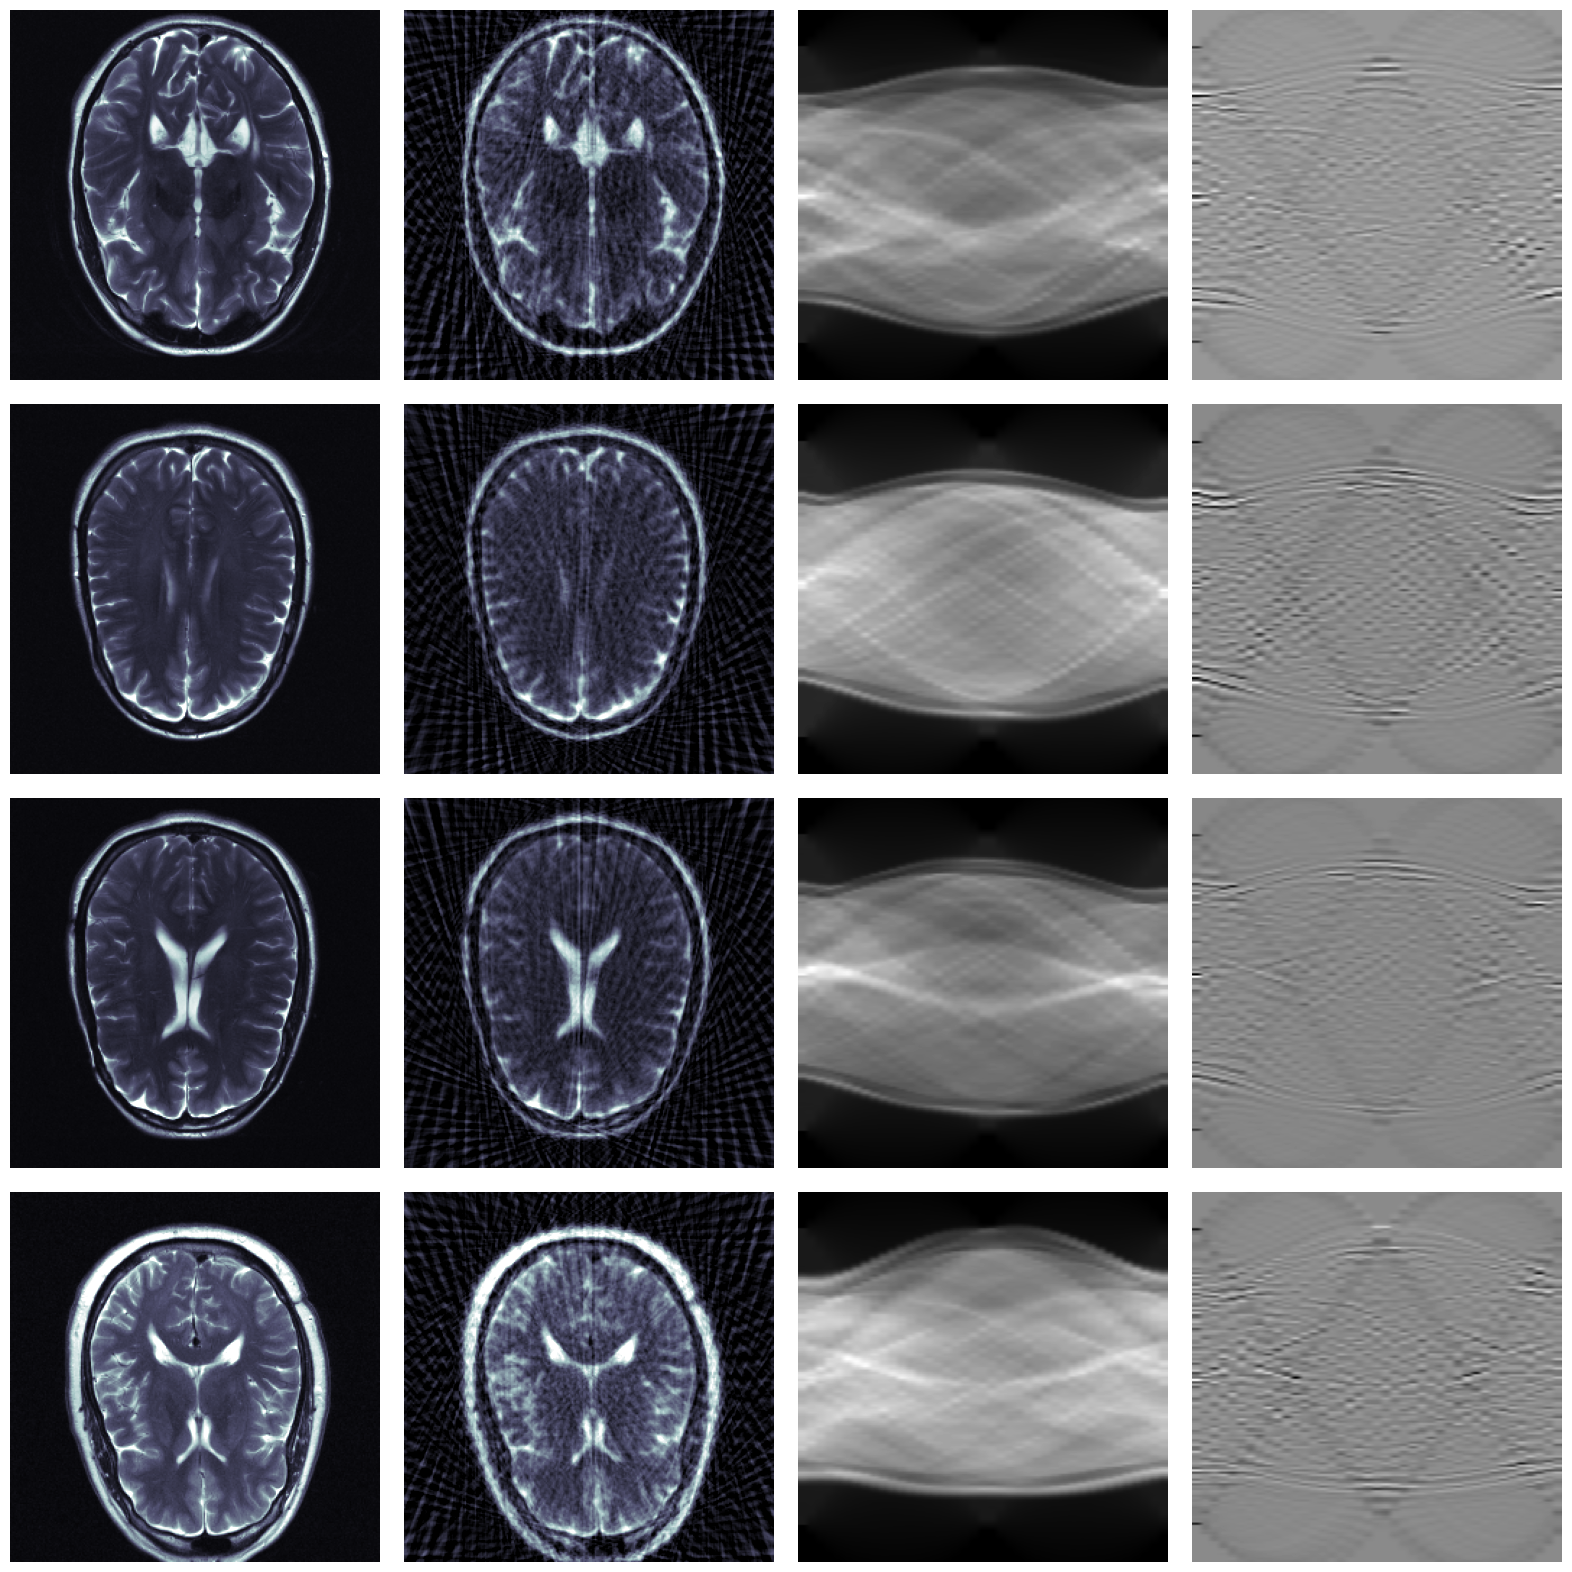

In [6]:
iimages = np.random.randint(0, len(brains), 4)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for iax, iimage in enumerate(iimages):
    axs[iax, 0].imshow(brains[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 0].axis("tight")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(brainsfbp[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 1].axis("off")
    axs[iax, 1].axis("tight")
    axs[iax, 2].imshow(sinograms[iimage].T, cmap="gray")
    axs[iax, 2].axis("off")
    axs[iax, 2].axis("tight")
    axs[iax, 3].imshow(sinograms[iimage].T-(Cop @ brainsfbp[iimage]).T, cmap="gray")
    axs[iax, 3].axis("off")
    axs[iax, 3].axis("tight")
plt.tight_layout()

In [7]:
# Create train/validation set
X0_train, X0_valid, Y_train, Y_valid, X_train, X_valid = train_test_split(brainsfbp, brains, sinograms, 
                                                                          test_size=0.2, random_state=42)

In [8]:
# Convert Train Set to Torch
X0_train = torch.from_numpy(X0_train).float().unsqueeze(1)
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train = torch.from_numpy(Y_train).float().unsqueeze(1)
train_dataset = TensorDataset(X0_train, X_train, Y_train)

# Define Valid Set to Torch
X0_valid = torch.from_numpy(X0_valid).float().unsqueeze(1)
X_valid = torch.from_numpy(X_valid).float().unsqueeze(1)
Y_valid = torch.from_numpy(Y_valid).float().unsqueeze(1)
valid_dataset = TensorDataset(X0_valid, X_valid, Y_valid)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
niter = 5
network = Learned(2, 16, 1, niter, Cop_torch)
summary(network.net, input_size=(1, 2, nx, ny))

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.
/opt/anaconda3/envs/pylops/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Layer (type:depth-idx)                             Output Shape              Param #
ResUNet                                            [1, 1, 256, 256]          --
├─ResNetBlock: 1-1                                 [1, 16, 256, 256]         --
│    └─Sequential: 2-1                             [1, 16, 256, 256]         --
│    │    └─Conv2d: 3-1                            [1, 16, 256, 256]         32
│    │    └─BatchNorm2d: 3-2                       [1, 16, 256, 256]         32
│    └─Sequential: 2-2                             [1, 16, 256, 256]         --
│    │    └─Sequential: 3-3                        [1, 16, 256, 256]         320
│    │    └─Sequential: 3-4                        [1, 16, 256, 256]         2,336
│    └─LeakyReLU: 2-3                              [1, 16, 256, 256]         --
│    └─BatchNorm2d: 2-4                            [1, 16, 256, 256]         32
├─Sequential: 1-2                                  --                        --
│    └─ContractingBlock_Res: 2-

In [10]:
if trainnet:
    n_epochs = 30
    lr = 1e-3 
    
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(network.parameters(), lr=lr)

    train_loss_history = np.zeros(n_epochs)
    valid_loss_history = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        train_loss = train(network, criterion, optim, 
                           train_loader, device=device)
        valid_loss = evaluate(network, criterion, 
                              valid_loader, device=device)
        train_loss_history[epoch] = train_loss
        valid_loss_history[epoch] = valid_loss
        
        print(f'Epoch {epoch}, Training Loss {train_loss:.4f}, Valid Loss {valid_loss:.4f}')

    # Save model
    torch.save(network.state_dict(), '../models/Learned.pt')

else:   
    criterion = nn.MSELoss()
    
    # Load model
    network.load_state_dict(torch.load('../models/Learned.pt'))    

In [11]:
if trainnet:
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(train_loss_history, 'k', lw=2, label='Train')
    ax.plot(valid_loss_history, 'r', lw=2, label='Valid')
    ax.set_title('Losses', fontweight='bold');

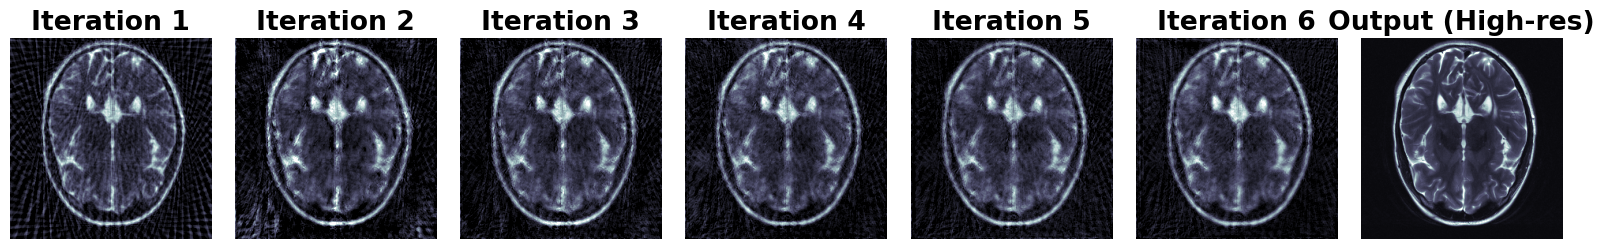

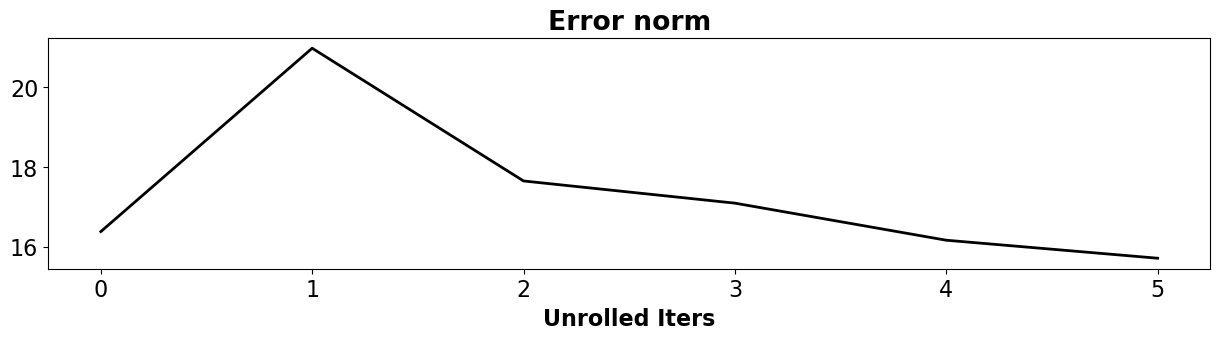

In [27]:
# Training predictions
iimage = 12
Y_train_pred, _ = network.forward_sequence(X0_train[iimage], X_train[iimage], Y_train[iimage], criterion)
loss_train = [np.linalg.norm(Y_train[iimage].ravel() - y.ravel()) for y in Y_train_pred]

fig, axs = plt.subplots(1, niter + 2, sharex=True, sharey=True, figsize=(16, 16))
axs[-1].imshow(Y_train[iimage].squeeze(), cmap="bone", vmin=0, vmax=.7)
axs[-1].axis("off")
for iax in range(niter+1):
    axs[iax].imshow(Y_train_pred[iax], cmap="bone", vmin=0, vmax=.7)
    axs[iax].axis("off")
    axs[iax].set_title(f"Iteration {iax+1}", fontweight="bold")
axs[-1].set_title("Output (High-res)", fontweight="bold")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(loss_train, 'k', lw=2)
ax.set_xlabel('Unrolled Iters', fontweight='bold')
ax.set_title('Error norm', fontweight='bold');

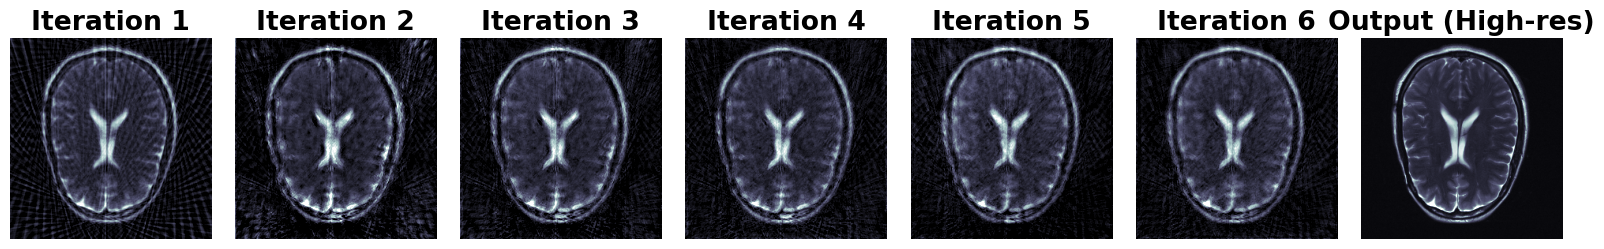

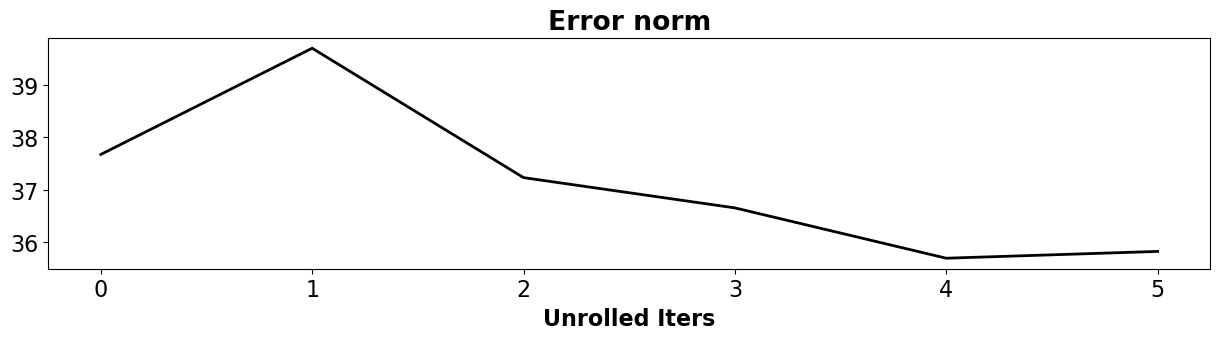

In [30]:
# Validation predictions
iimage = 0
Y_valid_pred, _ = network.forward_sequence(X0_valid[iimage], X_valid[iimage], Y_valid[iimage], criterion)
loss_valid = [np.linalg.norm(Y_valid[iimage].ravel() - y.ravel()) for y in Y_train_pred]

fig, axs = plt.subplots(1, niter + 2, sharex=True, sharey=True, figsize=(16, 16))
axs[-1].imshow(Y_valid[iimage].squeeze(), cmap="bone", vmin=0, vmax=.7)
axs[-1].axis("off")
for iax in range(niter+1):
    axs[iax].imshow(Y_valid_pred[iax], cmap="bone", vmin=0, vmax=.7)
    axs[iax].axis("off")
    axs[iax].set_title(f"Iteration {iax+1}", fontweight="bold")
axs[-1].set_title("Output (High-res)", fontweight="bold")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(loss_valid, 'k', lw=2)
ax.set_xlabel('Unrolled Iters', fontweight='bold')
ax.set_title('Error norm', fontweight='bold');

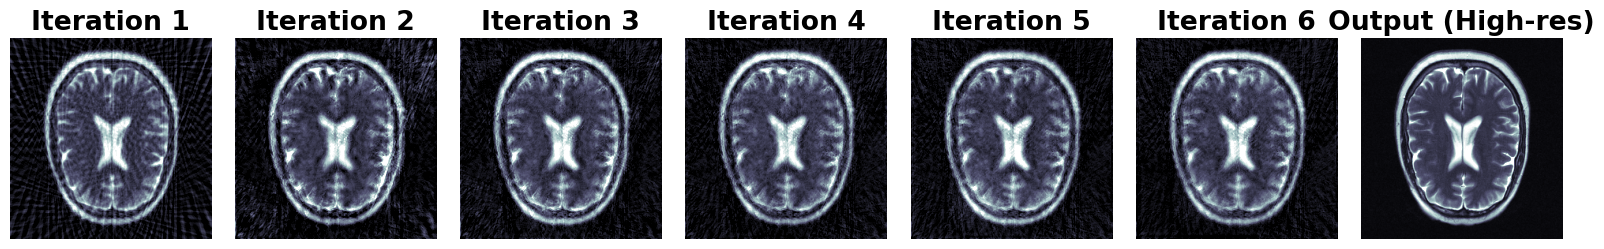

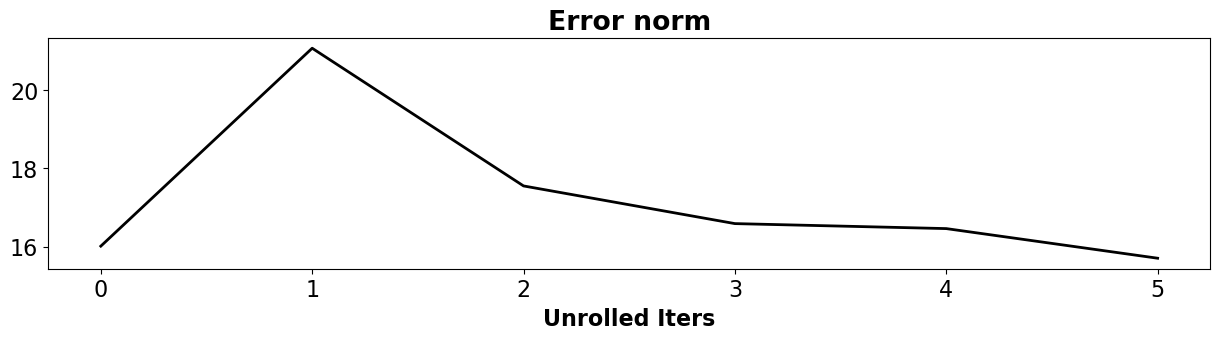

In [31]:
# Test prediction
brain_testpred, _ = network.forward_sequence(torch.from_numpy(brainfbp_test).unsqueeze(0), 
                                             torch.from_numpy(sinogram_test).unsqueeze(0), 
                                             torch.from_numpy(brain_test).unsqueeze(0), criterion)
loss_test = [np.linalg.norm(brain_test.ravel() - y.ravel()) for y in brain_testpred]

fig, axs = plt.subplots(1, niter + 2, sharex=True, sharey=True, figsize=(16, 16))
axs[-1].imshow(brain_test, cmap="bone", vmin=0, vmax=.7)
axs[-1].axis("off")
for iax in range(niter+1):
    axs[iax].imshow(brain_testpred[iax], cmap="bone", vmin=0, vmax=.7)
    axs[iax].axis("off")
    axs[iax].set_title(f"Iteration {iax+1}", fontweight="bold")
axs[-1].set_title("Output (High-res)", fontweight="bold")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(loss_test, 'k', lw=2)
ax.set_xlabel('Unrolled Iters', fontweight='bold')
ax.set_title('Error norm', fontweight='bold');

/Users/ravasim/Desktop/KAUST/2023/Teaching/DA_summerschool_2023/notebooks/plotting.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


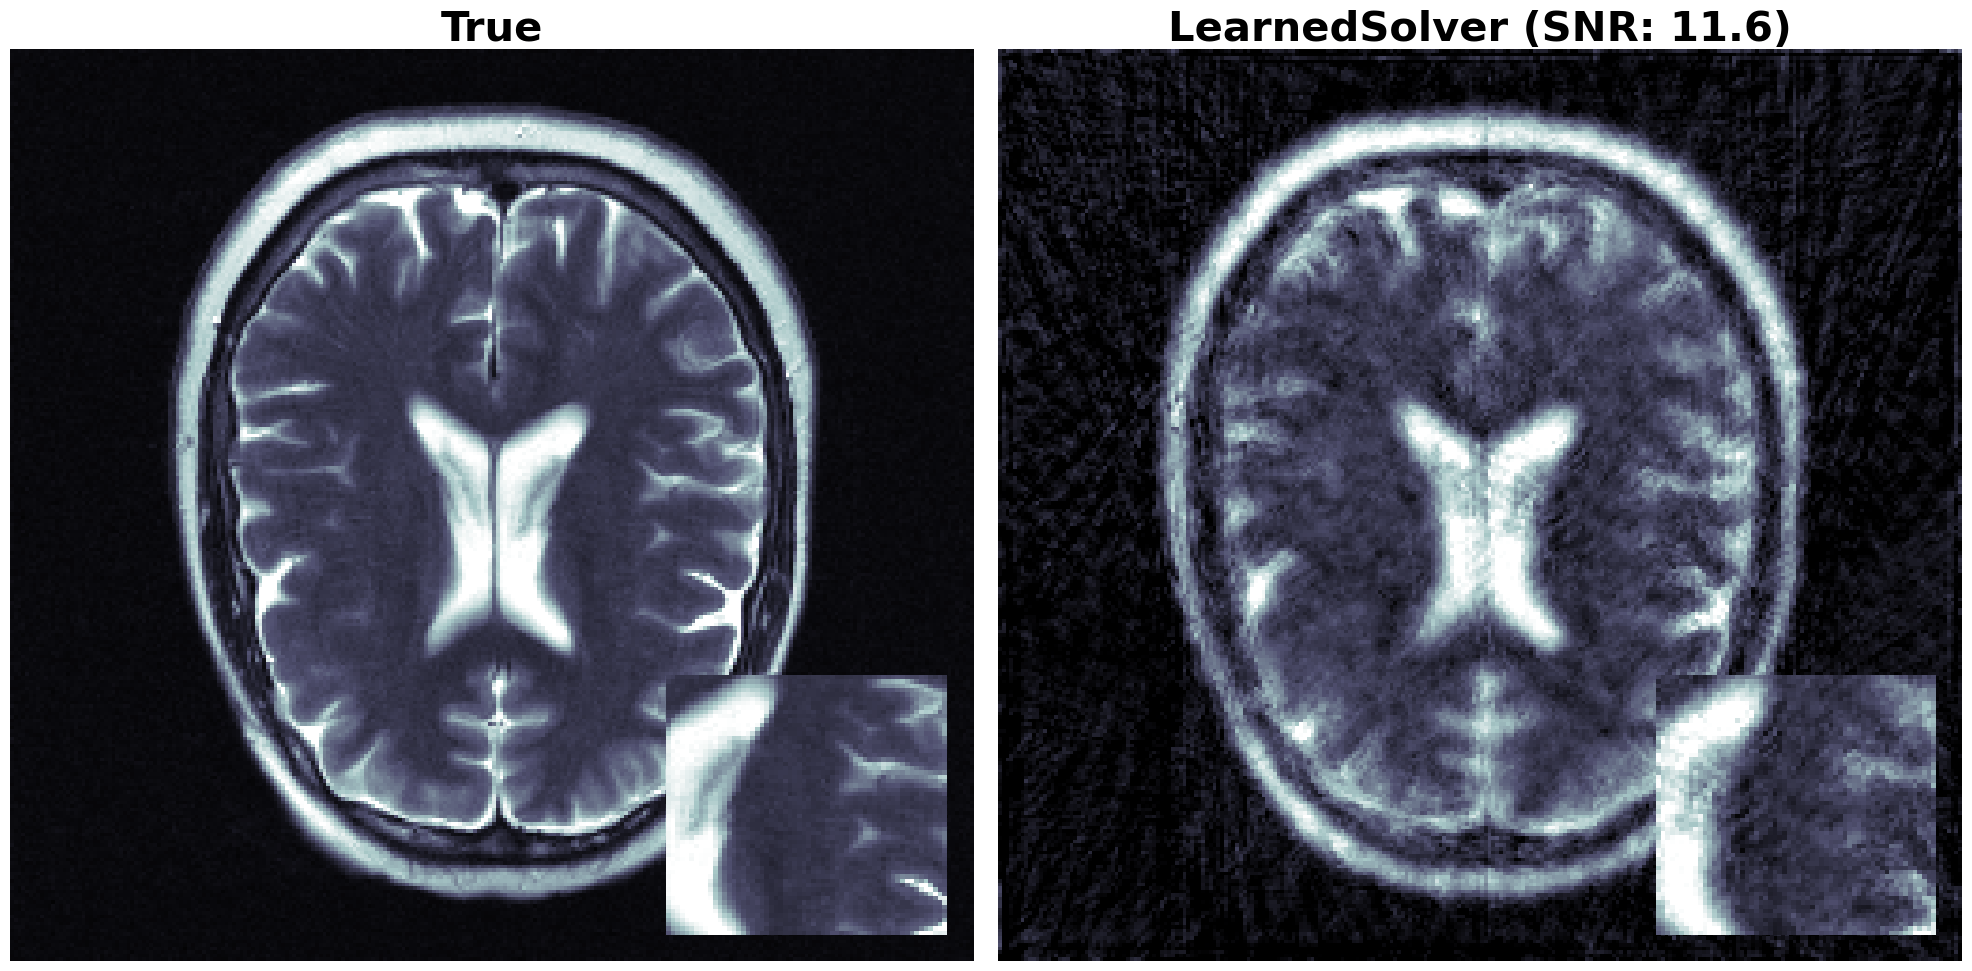

In [32]:
plt_comparison(brain_test, brain_testpred[-1], cmap='bone', clim=(0, 0.7), 
               titles=['True', 'LearnedSolver'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)